In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [29]:
def collect_data_and_plot(df, test_mode, setting_name, underage_cost):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'] + '/model.pt',
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/10/{row['Architecture Class']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 24:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_cost = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        n_samples = 32768
        batch_size = 32768
        num_batches = n_samples // batch_size
        if test_mode == 'test_on_dev':
            num_steps = 50
            start_step = 30
        else:
            num_steps = 200
            start_step = 100
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        n_stores = 10
        avg_s_underage.append(relevant_data['s_underage_costs'].mean() / underage_cost)
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / underage_cost)
        avg_w_holding.append(relevant_data['w_holding_costs'].mean() / underage_cost)
        avg_cost.append(relevant_data['s_underage_costs'].sum() + relevant_data['s_holding_costs'].sum() + relevant_data['w_holding_costs'].sum())

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding 
    df_copy['avg_cost'] = avg_cost
    df = df_copy

    # Print the average values for each architecture in a table format
    print("\nMetrics by Architecture and Differences:")
    print("-" * 80)
    print(f"{'Architecture':<15} {'Store Underage':>15} {'Store Holding':>15} {'Warehouse Holding':>18} {'Total Cost':>15}")
    print("-" * 80)
    
    archs = list(df['Architecture Class'].unique())
    arch1_data = df[df['Architecture Class'] == archs[0]]
    arch2_data = df[df['Architecture Class'] == archs[1]]
    
    # Print first architecture
    print(f"{archs[0]:<15} {arch1_data['avg_s_underage'].mean():>15.6f} {arch1_data['avg_s_holding'].mean():>15.6f} {arch1_data['avg_w_holding'].mean():>18.6f} {arch1_data['avg_cost'].mean():>15.2f}")
    
    # Print second architecture
    print(f"{archs[1]:<15} {arch2_data['avg_s_underage'].mean():>15.6f} {arch2_data['avg_s_holding'].mean():>15.6f} {arch2_data['avg_w_holding'].mean():>18.6f} {arch2_data['avg_cost'].mean():>15.2f}")
    
    # Print differences
    print("-" * 80)
    print("Differences (GNN - Vanilla):")
    print(f"{'':15} {arch1_data['avg_s_underage'].mean() - arch2_data['avg_s_underage'].mean():>15.6f} {arch1_data['avg_s_holding'].mean() - arch2_data['avg_s_holding'].mean():>15.6f} {arch1_data['avg_w_holding'].mean() - arch2_data['avg_w_holding'].mean():>18.6f} {arch1_data['avg_cost'].mean() - arch2_data['avg_cost'].mean():>15.2f}")
    print("-" * 80)

    # Calculate relative cost
    # Calculate cost as percentage of lowest cost
    # Calculate relative cost as percentage of minimum overall cost
    min_cost = df['avg_cost'].min()
    df['cost'] = df['avg_cost'] / min_cost * 100

    plot_data = df.pivot(columns='Architecture Class', 
                         values=['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Cost (% of minimum)', 'Average Store lost sales / (average unit underage cost)', 'Average Store Holding Cost / (average unit underage cost)', 'Average Warehouse Holding Cost / (average unit underage cost)']
    y_values = ['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Just_In_Time':
                continue
            if arch in plot_data[y_value].columns:
                plot_values = plot_data[y_value][arch].to_numpy()
                ax.plot(range(len(plot_values)), plot_values, marker='o', label=f'{arch}',
                        color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_xlabel('Sample')
        ax.set_ylabel(f'{title}')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    return df


One warehouse n stores real data(46 stores, 109 samples)
   store_underage_cost     Architecture Class  train_n_samples  Train Loss  Dev Loss  Test Loss  Test Gap %
0                    8                    GNN            32768    5.346495  5.345672   7.955832   47.623453
0                    8         GNN_longer_dev            32768    5.385146  5.382292   5.389273    0.000000
0                    8             Vanilla NN            32768    5.380864  5.389852   5.410690    0.397400
0                    8  Vanilla NN Longer Dev            32768    5.388241  5.394789   5.397793    0.158083


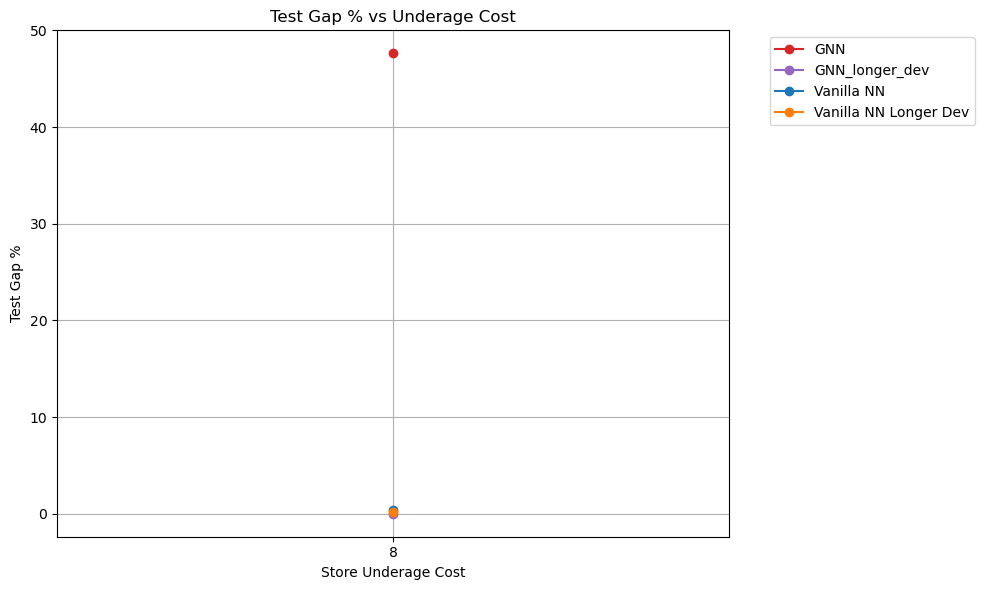

In [ ]:
# Define color scheme for architecture types
color_scheme = {
    "GNN": "#d62728",  # red
    "GNN_pna": "#2ca02c",  # green
    "Vanilla NN": "#1f77b4",  # Blue
    "GNN_longer_dev": "#9467bd",  # purple
    "Vanilla NN Longer Dev": "#ff7f0e",  # orange
}

linestyle_scheme = {
    "GNN": "-",
    "GNN_pna": "-", 
    "Vanilla NN": "-",
    "GNN_longer_dev": "-",
    "Vanilla NN Longer Dev": "-",
}

path = 'generic_architecture_n_warehouse'
gnn_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN',
}
gnn_pna_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN_pna',
}
vanilla_nn_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_n_warehouses',
}
gnn_longer_dev_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN_longer_dev',
}
vanilla_nn_longer_dev_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_n_warehouses_longer_dev',
}
def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
store_underage_cost = [8]
results_interpretor = rri.RayResultsinterpreter()

# GNN
df_gnn = results_interpretor.make_table(gnn_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 32768},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn.insert(1, 'hyperparam_name', "GNN")

# GNN PNA
df_gnn_pna = results_interpretor.make_table(gnn_pna_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 32768},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_pna.insert(1, 'Architecture Class', "GNN_pna")
df_gnn_pna.insert(1, 'hyperparam_name', "GNN_pna")

# Vanilla NN
df_vanilla = results_interpretor.make_table(vanilla_nn_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 32768},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(1, 'Architecture Class', "Vanilla NN")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_n_warehouses")

# GNN Longer Dev
df_gnn_longer_dev = results_interpretor.make_table(gnn_longer_dev_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 32768},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_longer_dev.insert(1, 'Architecture Class', "GNN_longer_dev")
df_gnn_longer_dev.insert(1, 'hyperparam_name', "GNN_longer_dev")

# Vanilla NN Longer Dev
df_vanilla_longer_dev = results_interpretor.make_table(vanilla_nn_longer_dev_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 32768},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla_longer_dev.insert(1, 'Architecture Class', "Vanilla NN Longer Dev")
df_vanilla_longer_dev.insert(1, 'hyperparam_name', "vanilla_n_warehouses_longer_dev")

# Combine dataframes
df = pd.concat([
    df_gnn, df_vanilla, df_gnn_longer_dev, df_vanilla_longer_dev# , df_gnn_pna
])

min_test_loss = df.groupby(['store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.drop(columns=['# of stores'], inplace=True)
df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

df_to_analyze = df.copy()
df_to_print = df.copy()
df_to_print.drop(columns=['hyperparam_name', 'Learning Rate', 'path', '# of runs'], inplace=True)
print("One warehouse n stores real data(46 stores, 109 samples)")
print(df_to_print.to_string())

# Create plot for Test Gap % vs Underage Cost
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Test Gap % - take best performing one (highest Test Gap %) for each group
pivot_df = df.groupby(['store_underage_cost', 'Architecture Class'])['Test Gap %'].min().unstack()

for column in pivot_df.columns:
    ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
            marker='o',
            label=column,
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Store Underage Cost')
ax.set_ylabel('Test Gap %')
ax.set_title('Test Gap % vs Underage Cost')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
ax.set_xticks(pivot_df.index)

plt.tight_layout()
plt.show()


Metrics by Architecture and Differences:
--------------------------------------------------------------------------------
Architecture     Store Underage   Store Holding  Warehouse Holding      Total Cost
--------------------------------------------------------------------------------
GNN                    1.940441        7.918191           0.089765    260791273.08
Vanilla NN             2.342739        4.303456           0.113972    177213739.18
--------------------------------------------------------------------------------
Differences (GNN - Vanilla):
                      -0.402298        3.614735          -0.024207     83577533.90
--------------------------------------------------------------------------------


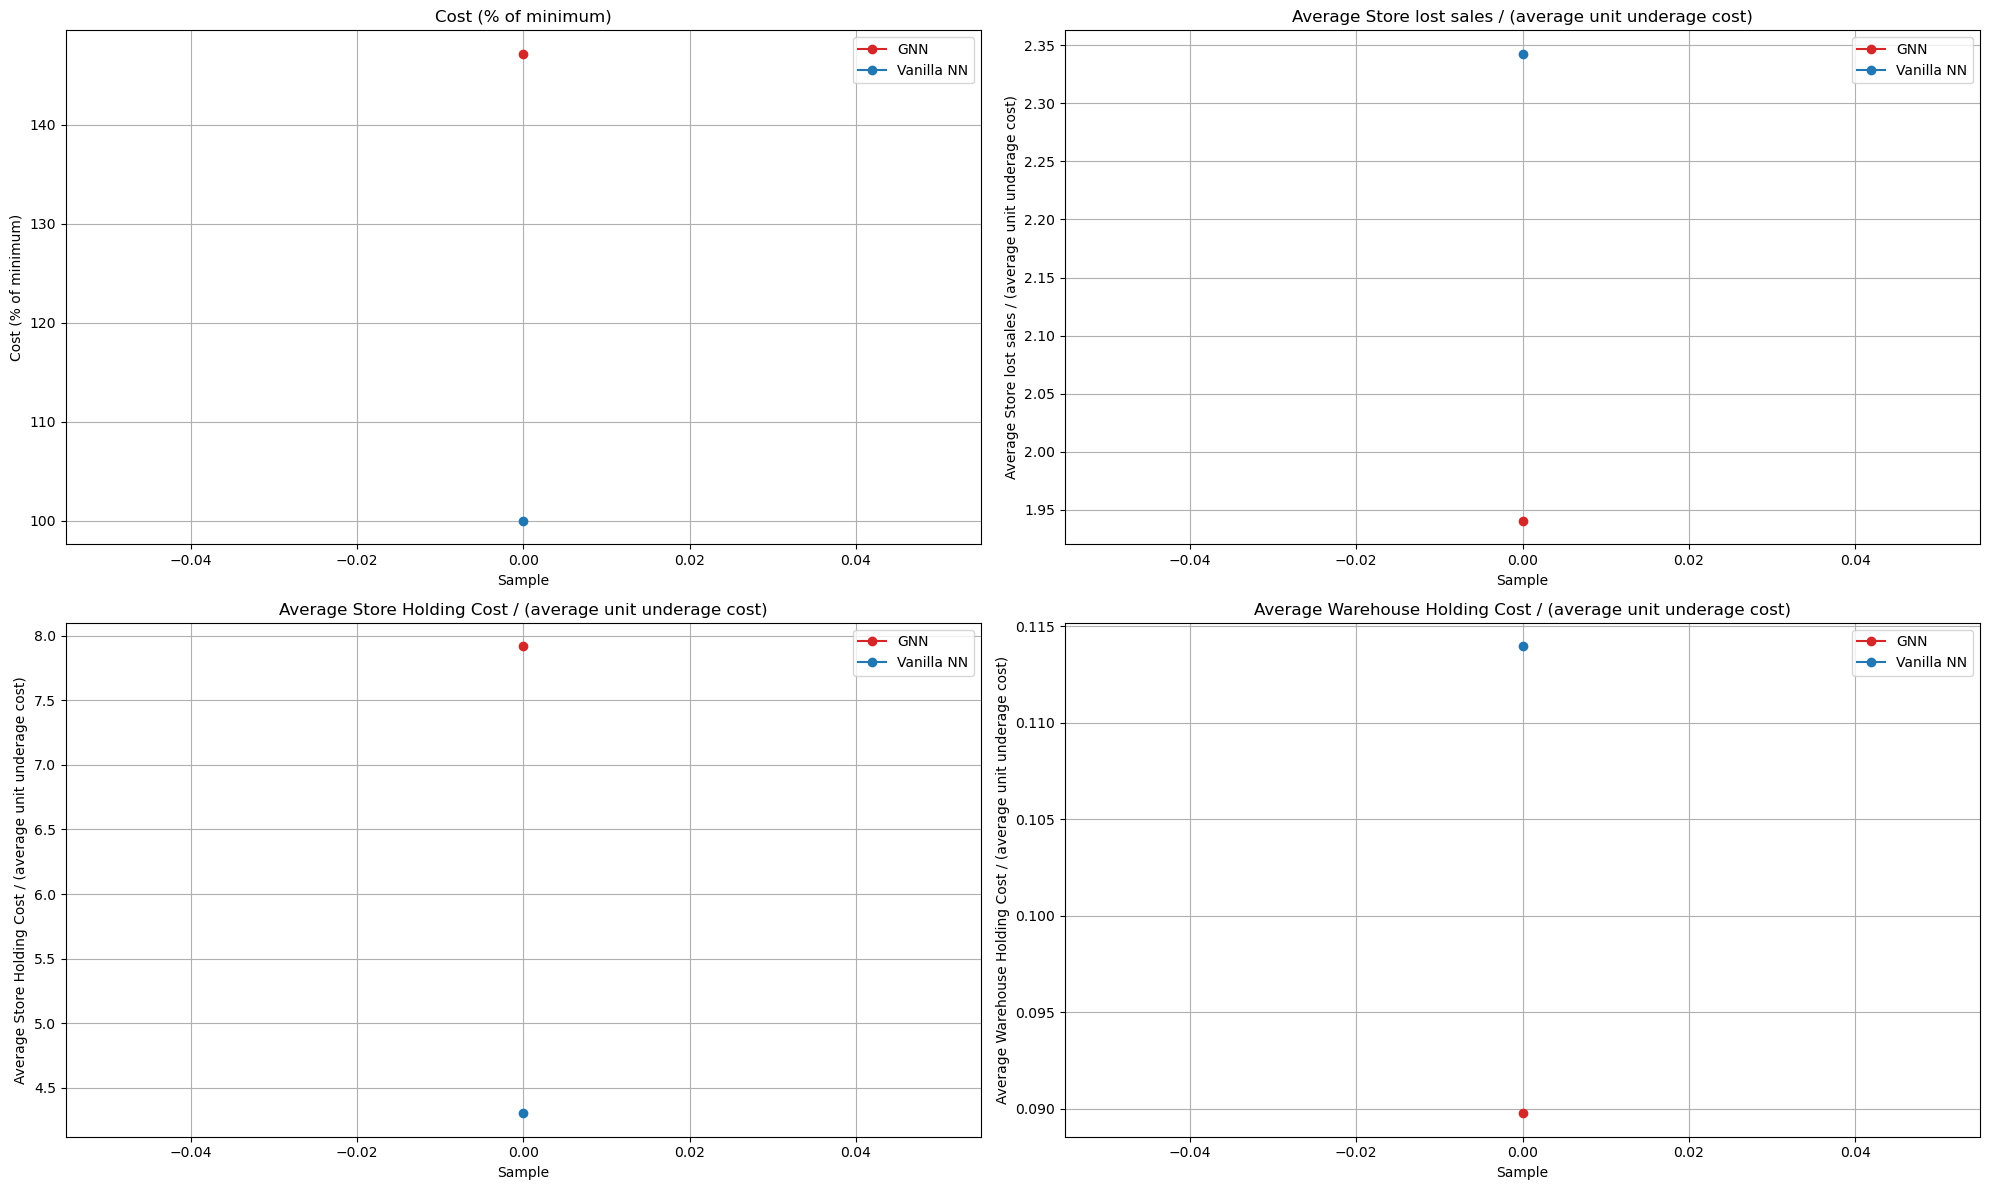

,store_underage_cost,hyperparam_name,Architecture Class,train_n_samples,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,Test Gap %,path,avg_s_underage,avg_s_holding,avg_w_holding,avg_cost,cost
0,8,GNN,GNN,32768,0.001,5.346495,5.345672,7.955832,41,47.039119,/user/ml4723/Prj/NIC/ray_results/generic_archi...,1.940441,7.918191,0.089765,2.607913e+08,147.161994
0,8,vanilla_n_warehouses,Vanilla NN,32768,0.001,5.380864,5.389852,5.410690,27,0.000000,/user/ml4723/Prj/NIC/ray_results/generic_archi...,2.342739,4.303456,0.113972,1.772137e+08,100.000000


In [15]:
collect_data_and_plot(df_to_analyze, 'test', 'n_warehouse_lost_demand', 8.0)

In [33]:
# Calculate average improvement of GNN_MP over other architectures in Dev Loss across all underage costs
architectures = ['Vanilla NN Longer Dev']
improvements = {}

for arch in architectures:
    # Get Dev Loss for each architecture and GNN_MP for all underage costs
    arch_losses = df[df['Architecture Class'] == arch]['Test Loss']
    gnn_losses = df[df['Architecture Class'] == 'GNN_longer_dev']['Test Loss']
    
    # Calculate relative improvement for each underage cost and average
    if not arch_losses.empty and not gnn_losses.empty:
        improvements = []
        for arch_loss, gnn_loss in zip(arch_losses, gnn_losses):
            improvement = ((arch_loss - gnn_loss) / arch_loss) * 100
            improvements.append(improvement)
        avg_improvement = sum(improvements) / len(improvements)
        print(f"GNN_MP improves {arch} by {avg_improvement:.2f}% in Test Loss on average")

GNN_MP improves Vanilla NN Longer Dev by 0.16% in Test Loss on average


One warehouse n stores real data(46 stores, 109 samples)
   store_underage_cost     Architecture Class  train_n_samples  Train Loss  Dev Loss  Test Loss  Test Gap %
0                    8                    GNN               16    5.326170  5.345250   5.750079    1.774513
0                    8         GNN_longer_dev               16    5.386085  5.310213   5.649822    0.000000
0                    8             Vanilla NN               16    5.275868  6.227479   6.536829   15.699721
0                    8  Vanilla NN Longer Dev               16    5.451688  6.085645   6.399520   13.269404


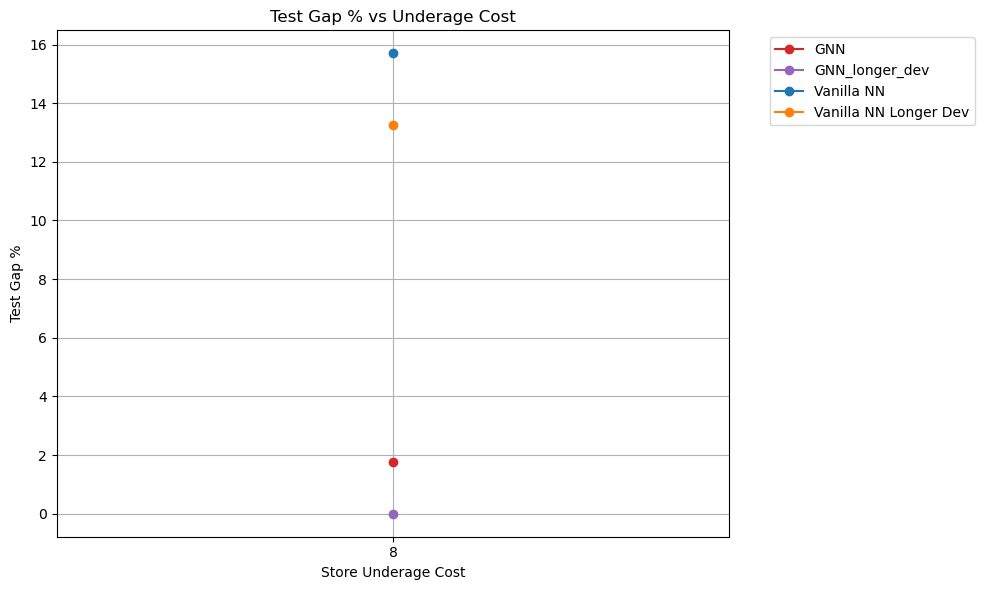

In [3]:
# Define color scheme for architecture types
color_scheme = {
    "GNN": "#d62728",  # red
    "Vanilla NN": "#1f77b4",  # Blue
    "GNN_longer_dev": "#9467bd",  # purple
    "Vanilla NN Longer Dev": "#ff7f0e",  # orange
}

linestyle_scheme = {
    "GNN": "-",
    "Vanilla NN": "-", 
    "GNN_longer_dev": "-",
    "Vanilla NN Longer Dev": "-"
}

path = 'generic_architecture_n_warehouse'
gnn_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN',
}
vanilla_nn_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_n_warehouses',
}
gnn_longer_dev_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN_longer_dev',
}
vanilla_nn_longer_dev_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_n_warehouses_longer_dev',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
store_underage_cost = [8]
results_interpretor = rri.RayResultsinterpreter()

# GNN
df_gnn = results_interpretor.make_table(gnn_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 16},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn.insert(1, 'hyperparam_name', "GNN")

# Vanilla NN
df_vanilla = results_interpretor.make_table(vanilla_nn_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 16},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(1, 'Architecture Class', "Vanilla NN")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_n_warehouses")

# GNN Longer Dev
df_gnn_longer = results_interpretor.make_table(gnn_longer_dev_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 16},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_longer.insert(1, 'Architecture Class', "GNN_longer_dev")
df_gnn_longer.insert(1, 'hyperparam_name', "GNN_longer_dev")

# Vanilla NN Longer Dev
df_vanilla_longer = results_interpretor.make_table(vanilla_nn_longer_dev_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 16},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla_longer.insert(1, 'Architecture Class', "Vanilla NN Longer Dev")
df_vanilla_longer.insert(1, 'hyperparam_name', "vanilla_n_warehouses_longer_dev")

# Combine dataframes
df = pd.concat([
    df_gnn, df_vanilla, df_gnn_longer, df_vanilla_longer
])

min_test_loss = df.groupby(['store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.drop(columns=['# of stores'], inplace=True)
df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

df_to_print = df.copy()
df_to_print.drop(columns=['hyperparam_name', 'Learning Rate', 'path', '# of runs'], inplace=True)
print("One warehouse n stores real data(46 stores, 109 samples)")
print(df_to_print.to_string())

# Create plot for Test Gap % vs Underage Cost
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Test Gap % - take best performing one (highest Test Gap %) for each group
pivot_df = df.groupby(['store_underage_cost', 'Architecture Class'])['Test Gap %'].min().unstack()

for column in pivot_df.columns:
    ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
            marker='o',
            label=column,
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Store Underage Cost')
ax.set_ylabel('Test Gap %')
ax.set_title('Test Gap % vs Underage Cost')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
ax.set_xticks(pivot_df.index)

plt.tight_layout()
plt.show()  

In [35]:
# Calculate average improvement of GNN_MP over other architectures in Dev Loss across all underage costs
architectures = ['Vanilla NN Longer Dev']
improvements = {}

for arch in architectures:
    # Get Dev Loss for each architecture and GNN_MP for all underage costs
    arch_losses = df[df['Architecture Class'] == arch]['Test Loss']
    gnn_losses = df[df['Architecture Class'] == 'GNN_longer_dev']['Test Loss']
    
    # Calculate relative improvement for each underage cost and average
    if not arch_losses.empty and not gnn_losses.empty:
        improvements = []
        for arch_loss, gnn_loss in zip(arch_losses, gnn_losses):
            improvement = ((arch_loss - gnn_loss) / arch_loss) * 100
            improvements.append(improvement)
        avg_improvement = sum(improvements) / len(improvements)
        print(f"GNN_MP improves {arch} by {avg_improvement:.2f}% in Dev Loss on average")

GNN_MP improves Vanilla NN Longer Dev by 11.71% in Dev Loss on average
